# Walmart : predict weekly sales

### Librairies

In [43]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# pio.renderers.default = "svg"

import warnings
warnings.filterwarnings('ignore')

### The dataset

In [2]:
df = pd.read_csv("src\Walmart_Store_sales.csv")

In [3]:
# Basic information
print("Number of rows :", df.shape[0])
print()     
print("Display of the dataset :")
display(df.head())
print("Basic statistics :")
data_desc = df.describe(include="all")
display(data_desc)
print("Percentage of missing values :")
display(100*df.isnull().sum()/df.shape[0])

Number of rows : 150

Display of the dataset :


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


Basic statistics :


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


Percentage of missing values :


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

### EDA

In [4]:
# Delete rows where target variable Weekly_sales is missing
df = df.dropna(subset=["Weekly_Sales"])
print("Percentage of missing values :")
display(100*df.isnull().sum()/df.shape[0])
print("Number of rows :", df.shape[0])

Percentage of missing values :


Store            0.000000
Date            13.235294
Weekly_Sales     0.000000
Holiday_Flag     8.088235
Temperature     11.029412
Fuel_Price       8.823529
CPI              8.088235
Unemployment    10.294118
dtype: float64

Number of rows : 136


In [5]:
# Convert date column into the right format
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")

# Extract year, month, day, and day of the week
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["Day_of_week"] = df["Date"].dt.dayofweek

# Drop date column 
df = df.drop("Date", axis=1)

df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,Day_of_week
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0,4.0
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0,4.0
3,11.0,1244390.03,0.0,84.57,NaN,214.556497,7.346,NaN,NaN,NaN,NaN
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0,4.0
5,4.0,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010.0,5.0,28.0,4.0


In [6]:
# Removing outliers that don't fit the the range : [X̄ - 3σ, X̄ + 3σ]
cols = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]

for col in cols:
    mean = df[col].mean()
    std = df[col].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print("Number of rows :", df.shape[0])

Number of rows : 90


In [7]:
# Replace missing values from Holiday_flag by the most frequent
df["Holiday_Flag"] = df["Holiday_Flag"].replace(np.nan, 0)

# Replace numerical values by their real label as the variable is categorical
df["Holiday"] = df["Holiday_Flag"].map({
    0:"Non-holiday week",
    1:"Holiday week"
})

df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,Day_of_week,Holiday
0,6.0,1572117.54,0.0,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0,4.0,Non-holiday week
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0,4.0,Non-holiday week
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0,4.0,Non-holiday week
6,15.0,695396.19,0.0,69.80,4.069,134.855161,7.658,2011.0,6.0,3.0,4.0,Non-holiday week
7,20.0,2203523.20,0.0,39.93,3.617,213.023622,6.961,2012.0,2.0,3.0,4.0,Non-holiday week


In [8]:
# Delete previous flag
df.drop("Holiday_Flag", axis=1, inplace=True)

df.head()

,Store,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,Day_of_week,Holiday
0,6.0,1572117.54,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0,4.0,Non-holiday week
1,13.0,1807545.43,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0,4.0,Non-holiday week
4,6.0,1644470.66,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0,4.0,Non-holiday week
6,15.0,695396.19,69.80,4.069,134.855161,7.658,2011.0,6.0,3.0,4.0,Non-holiday week
7,20.0,2203523.20,39.93,3.617,213.023622,6.961,2012.0,2.0,3.0,4.0,Non-holiday week


### Preprocessing

In [9]:
# Separate target variable Y from features X
target_name = "Weekly_Sales"

print("Separating labels from features...")
Y = df.loc[:,target_name]
X = df.drop(target_name, axis=1)

print("...Done.")
print()

print("Y : ")
display(Y.head())
print()
print("X : ")
display(X.head())
print()

Separating labels from features...
...Done.

Y : 


0    1572117.54
1    1807545.43
4    1644470.66
6     695396.19
7    2203523.20
Name: Weekly_Sales, dtype: float64


X : 


,Store,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,Day_of_week,Holiday
0,6.0,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0,4.0,Non-holiday week
1,13.0,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0,4.0,Non-holiday week
4,6.0,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0,4.0,Non-holiday week
6,15.0,69.80,4.069,134.855161,7.658,2011.0,6.0,3.0,4.0,Non-holiday week
7,20.0,39.93,3.617,213.023622,6.961,2012.0,2.0,3.0,4.0,Non-holiday week


In [10]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [11]:
# Separate numerical and categorical features
numeric_features = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "Year", "Month", "Day", "Day_of_week"]
categorical_features = ["Store", "Holiday"]

In [12]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")), # missing values will be replaced by columns" mean
    ("scaler", StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ("encoder", OneHotEncoder(drop="first")) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

In [13]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test)
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
     Store  Temperature  Fuel_Price         CPI  Unemployment    Year  Month  \
127   16.0        61.79       2.711  189.523128         6.868  2010.0    7.0   
63     5.0        69.17       3.594  224.019287         5.422  2012.0   10.0   
35    19.0        33.26       3.789  133.958742         7.771  2011.0    3.0   
10     8.0        82.92       3.554  219.070197         6.425  2011.0    8.0   
95     1.0        74.78       2.854  210.337426         7.808  2010.0    5.0   

      Day  Day_of_week           Holiday  
127   9.0          4.0  Non-holiday week  
63   19.0          4.0  Non-holiday week  
35   25.0          4.0  Non-holiday week  
10   19.0          4.0  Non-holiday week  
95   14.0          4.0  Non-holiday week  
...Done.
[[ 0.04260362 -1.26840641  0.20507788 -0.55534542 -1.15712571  0.16826221
  -0.86354705  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0

### Train model

In [14]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


### Performance assessment

In [15]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("Done")

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("Done")

Predictions on training set...
Done
Predictions on test set...
Done


In [16]:
# Print R2 scores
print("R2 score on training set : ", regressor.score(X_train, Y_train))
print("R2 score on test set : ", regressor.score(X_test, Y_test))

R2 score on training set :  0.9868327769375977
R2 score on test set :  0.9351220145872654


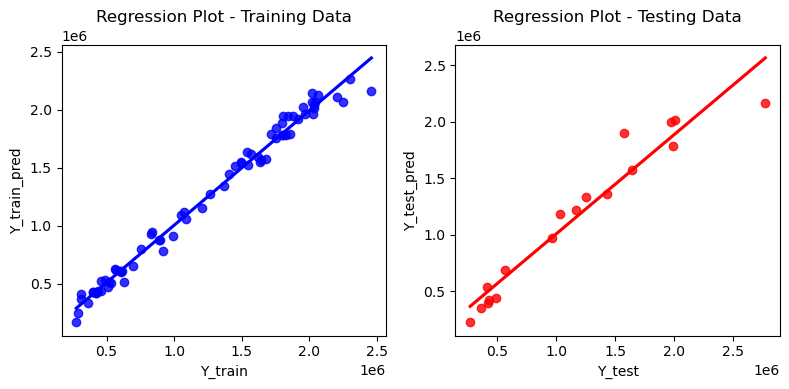

In [17]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjust the figure size if needed

# First Graph: Training Data
sns.regplot(x=Y_train, y=Y_train_pred, ci=None, color="blue", ax=axes[0])
axes[0].set_xlabel("Y_train")
axes[0].set_ylabel("Y_train_pred")
axes[0].set_title("Regression Plot - Training Data", y=1.05)

# Second Graph: Testing Data
sns.regplot(x=Y_test, y=Y_test_pred, ci=None, color="red", ax=axes[1])
axes[1].set_xlabel("Y_test")
axes[1].set_ylabel("Y_test_pred")
axes[1].set_title("Regression Plot - Testing Data", y=1.05)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [18]:
# Let's have a look at the coefficients
regressor.coef_

array([-1.15202751e+04, -5.78174758e+04,  7.20656927e+05,  3.22099599e+04,
       -7.48177052e+03,  1.70579263e+04, -4.96454206e+04,  3.23634595e-08,
        2.71351161e+05, -1.25158801e+06,  2.21080233e+06, -1.22782285e+06,
        9.98806584e+04, -6.17603155e+05, -6.56894861e+05, -1.10322592e+06,
        1.80591202e+06,  2.19302069e+05,  2.07376418e+06,  1.01997373e+06,
        5.95670468e+05, -5.76278432e+05,  8.62696766e+05,  9.94166270e+05,
        1.33472263e+06,  5.92603702e+05,  5.36200219e+04])

In [19]:
# Get the name of the features created during preprocessing
column_names = []
for name, pipeline, features_list in preprocessor.transformers_:
    if name == "num":
        features = features_list
    else:
        features = pipeline.named_steps["encoder"].get_feature_names_out()
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day', 'Day_of_week', 'Store_2.0', 'Store_3.0', 'Store_4.0', 'Store_5.0', 'Store_6.0', 'Store_7.0', 'Store_8.0', 'Store_9.0', 'Store_10.0', 'Store_11.0', 'Store_13.0', 'Store_14.0', 'Store_15.0', 'Store_16.0', 'Store_17.0', 'Store_18.0', 'Store_19.0', 'Store_20.0', 'Holiday_Non-holiday week']


In [20]:
# Create a dataframe for the coefficients
coefs = pd.DataFrame(index = column_names, data = regressor.coef_.transpose(), columns=["coefficients"])

# Compute abs() and sort values
feature_importance = abs(coefs).sort_values(by="coefficients")
feature_importance

,coefficients
Day_of_week,3.236346e-08
Year,7.481771e+03
Temperature,1.152028e+04
Month,1.705793e+04
Unemployment,3.220996e+04
Day,4.964542e+04
Holiday_Non-holiday week,5.362002e+04
Fuel_Price,5.781748e+04
Store_6.0,9.988066e+04
Store_11.0,2.193021e+05


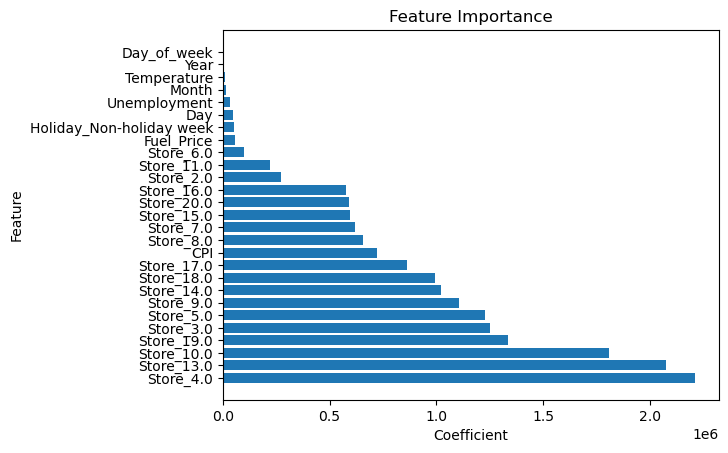

In [40]:
# Convert index and values to lists
feature_names = feature_importance.index.to_numpy()
importance_values = feature_importance.values
importance_values_reshape = importance_values.ravel() # from 2d to 1d array

# Plot coefficients
plt.barh(feature_names, importance_values_reshape)
plt.gca().invert_yaxis()  # Invert y-axis for orientation
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

### Fight overfitting

#### Ridge

In [41]:
reg_ridge = Ridge()

# Grid of values to be tested
params = {
    'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
} 

best_ridge = GridSearchCV(reg_ridge, param_grid = params, cv = 5)
best_ridge.fit(X_train, Y_train)

print("Best hyperparameters : ", best_ridge.best_params_)
print("Best R2 score : ", best_ridge.best_score_)

Best hyperparameters :  {'alpha': 0.01}
Best R2 score :  0.9529219375482801


#### Lasso

In [44]:
reg_lasso = Lasso()

# Grid of values to be tested
params = {
    'alpha': [1, 2, 3, 5, 10, 20, 30]
}

best_lasso = GridSearchCV(reg_lasso, param_grid = params, cv = 5)
best_lasso.fit(X_train, Y_train)

print("Best hyperparameters : ", best_lasso.best_params_)
print("Best R2 score : ", best_lasso.best_score_)

Best hyperparameters :  {'alpha': 20}
Best R2 score :  0.95326077115816


#### Comparison

In [ ]:
# Print R^2 scores
print("RIDGE / R2 score on training set : ", best_ridge.score(X_train, Y_train))
print("RIDGE / R2 score on test set : ", best_ridge.score(X_test, Y_test))
print()
print("LASSO / R2 score on training set : ", best_lasso.score(X_train, Y_train))
print("LASSO / R2 score on test set : ", best_lasso.score(X_test, Y_test))

RIDGE / R2 score on training set :  0.9860943774773433
RIDGE / R2 score on test set :  0.9387472424418064

LASSO / R2 score on training set :  0.9863989394506019
LASSO / R2 score on test set :  0.9389069706456831
